The purpose of this project is to find a model to predict whether a particular borrower will default on their loans.  The data is from the company Prosper, shared on Kaggle here - https://www.kaggle.com/datasets/shikhar07/prosper-loan-data?resource=download - and a key to the columns can be found here: https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0.  Since there are 81 columns, I will be careful to work with subsets of the information, to prevent slowing down programs and getting flooded with information.  

In [1]:
import pandas as pd

file_path = "/Users/Micah.isser/downloads/prosperLoanData.csv"

try:
    df = pd.read_csv(file_path)
    print("CSV file loaded successfully")
except Exception as e:
    print("An error occured:", e)

CSV file loaded successfully


In [2]:
print(df.describe())

       ListingNumber           Term    BorrowerAPR   BorrowerRate  \
count   1.139370e+05  113937.000000  113912.000000  113937.000000   
mean    6.278857e+05      40.830248       0.218828       0.192764   
std     3.280762e+05      10.436212       0.080364       0.074818   
min     4.000000e+00      12.000000       0.006530       0.000000   
25%     4.009190e+05      36.000000       0.156290       0.134000   
50%     6.005540e+05      36.000000       0.209760       0.184000   
75%     8.926340e+05      36.000000       0.283810       0.250000   
max     1.255725e+06      60.000000       0.512290       0.497500   

         LenderYield  EstimatedEffectiveYield  EstimatedLoss  EstimatedReturn  \
count  113937.000000             84853.000000   84853.000000     84853.000000   
mean        0.182701                 0.168661       0.080306         0.096068   
std         0.074516                 0.068467       0.046764         0.030403   
min        -0.010000                -0.182700       0.

Now let's pare down the data to the 15 most important columns, so that it is easier to find patterns between them.  I'll save the original (complete) data frame as 'original_df' and a smaller version as df, then re-save it as a new csv

In [3]:
original_df = df.copy()

important_variables = [
     'ListingCreationDate', 
    'Term', 
    'LoanStatus', 
    'BorrowerAPR', 
    'ProsperRating (Alpha)', 
    'ProsperScore', 
    'EmploymentStatus', 
    'IsBorrowerHomeowner', 
    'IncomeRange', 
    'LoanOriginalAmount',
    'MonthlyLoanPayment',
    'StatedMonthlyIncome',
    'AvailableBankcardCredit',
    'CreditScoreRangeLower',
    'CreditScoreRangeUpper'
]

df = df[important_variables]

df.to_csv("df_pared_down.csv", index=False)

print(df.head())

print(df.shape)

             ListingCreationDate  Term LoanStatus  BorrowerAPR  \
0  2007-08-26 19:09:29.263000000    36  Completed      0.16516   
1  2014-02-27 08:28:07.900000000    36    Current      0.12016   
2  2007-01-05 15:00:47.090000000    36  Completed      0.28269   
3  2012-10-22 11:02:35.010000000    36    Current      0.12528   
4  2013-09-14 18:38:39.097000000    36    Current      0.24614   

  ProsperRating (Alpha)  ProsperScore EmploymentStatus  IsBorrowerHomeowner  \
0                   NaN           NaN    Self-employed                 True   
1                     A           7.0         Employed                False   
2                   NaN           NaN    Not available                False   
3                     A           9.0         Employed                 True   
4                     D           4.0         Employed                 True   

      IncomeRange  LoanOriginalAmount  MonthlyLoanPayment  \
0  $25,000-49,999                9425              330.43   
1  $50

Now let's start to clean the data, looking for missing/NA values, duplicate rows, and extreme outliers.

In [4]:
missing_values = df.isnull().sum()
print("Missing/NA Values:")
print(missing_values)

duplicate_rows = df.duplicated().sum()
print("Duplicate Rows:")
print(duplicate_rows)

numerical_columns = df.select_dtypes(include=['number']).columns
outliers = {}
for column in numerical_columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    extreme_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    print("\nExtreme Outliers")
    print(outliers)

Missing/NA Values:
ListingCreationDate            0
Term                           0
LoanStatus                     0
BorrowerAPR                   25
ProsperRating (Alpha)      29084
ProsperScore               29084
EmploymentStatus            2255
IsBorrowerHomeowner            0
IncomeRange                    0
LoanOriginalAmount             0
MonthlyLoanPayment             0
StatedMonthlyIncome            0
AvailableBankcardCredit     7544
CreditScoreRangeLower        591
CreditScoreRangeUpper        591
dtype: int64
Duplicate Rows:
0

Extreme Outliers
{}

Extreme Outliers
{}

Extreme Outliers
{}

Extreme Outliers
{}

Extreme Outliers
{}

Extreme Outliers
{}

Extreme Outliers
{}

Extreme Outliers
{}

Extreme Outliers
{}


Good - so there are no missing/NA values for most rows, with the Prosper Score being the most often missing.   It's good that there are no duplicates or extreme outliers, so I'll assume that the data is fairly reliable.  Now I'd like to check about the format of the times/dates in some columns, to ensure that they're in a form that can easily be parse.  I'll use a regular expression to check the format of the dates.

In [5]:
import re

expected_format = '%Y-%m-%d %H:%M:%S.%f'
non_conforming_dates = df[~df['ListingCreationDate'].str.match(expected_format, na=False)]
print("Non-conforming date values:")
print(non_conforming_dates['ListingCreationDate'].head())

Non-conforming date values:
0    2007-08-26 19:09:29.263000000
1    2014-02-27 08:28:07.900000000
2    2007-01-05 15:00:47.090000000
3    2012-10-22 11:02:35.010000000
4    2013-09-14 18:38:39.097000000
Name: ListingCreationDate, dtype: object


The regular expression seems to be pulling all of the dates, since the time of day is defined to absurd degree of specificity. Since I don't actually need the time when the loans were taken out, so I'll truncate the values in ListingCreationDate to only have the calendar date.  

In [6]:
df['ListingCreationDate'] = df['ListingCreationDate'].str[:10]

df['ListingCreationDate'] = pd.to_datetime(df['ListingCreationDate'], format='%Y-%m-%d')

df['ListingCreationDate'] = df['ListingCreationDate'].dt.date
print(df['ListingCreationDate'].head())

0    2007-08-26
1    2014-02-27
2    2007-01-05
3    2012-10-22
4    2013-09-14
Name: ListingCreationDate, dtype: object


Now let's try to plot the dates of creation on a line graph using MatPlotLib. 

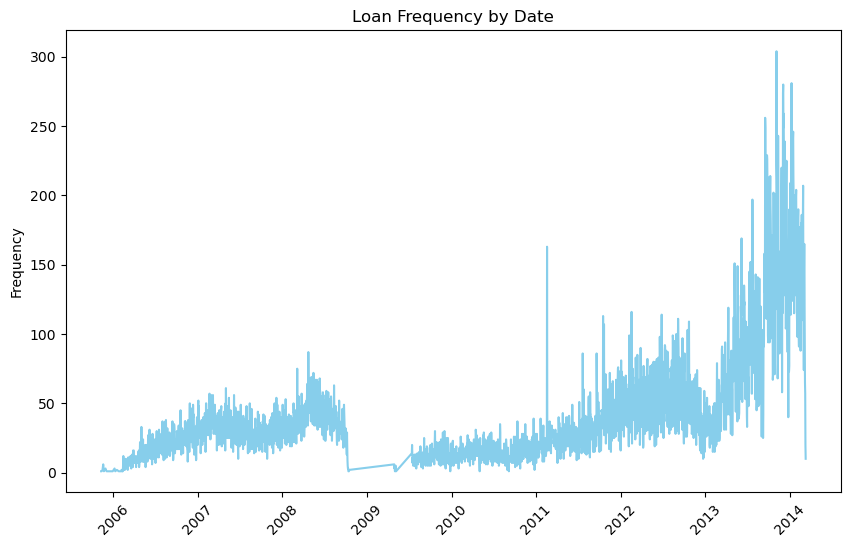

In [7]:
import matplotlib.pyplot as plt

df['ListingCreationDate'] = pd.to_datetime(df['ListingCreationDate'], format='%Y-%m-%d %H:%M:%S.%f')

loan_frequency = df['ListingCreationDate'].dt.date.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(loan_frequency.index, loan_frequency.values, color='skyblue')
plt.title('Loan Frequency by Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()

So now it becomes clear that Prosper gave far more loans near the end of 2013 and start of 2014 than they did in the period before that, apart from a large spike in 2011.  Let's similarly graph the frequency of the loan term and the loan status.

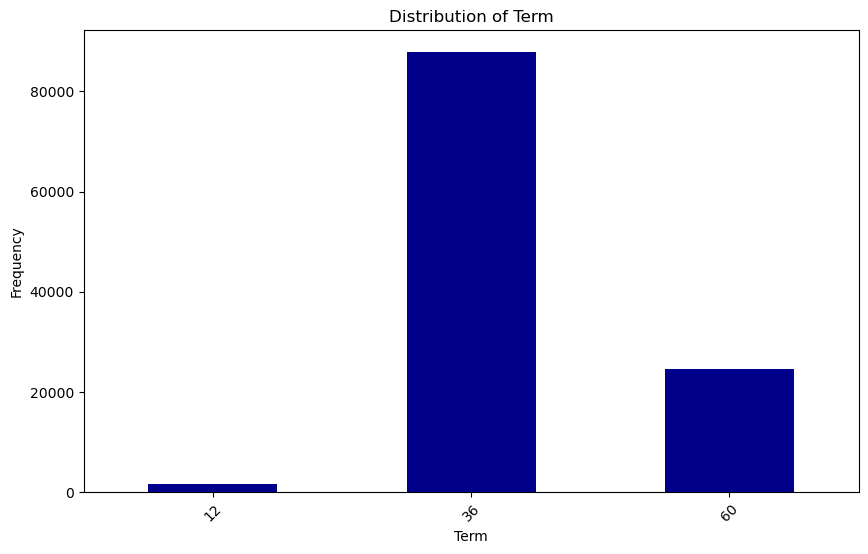

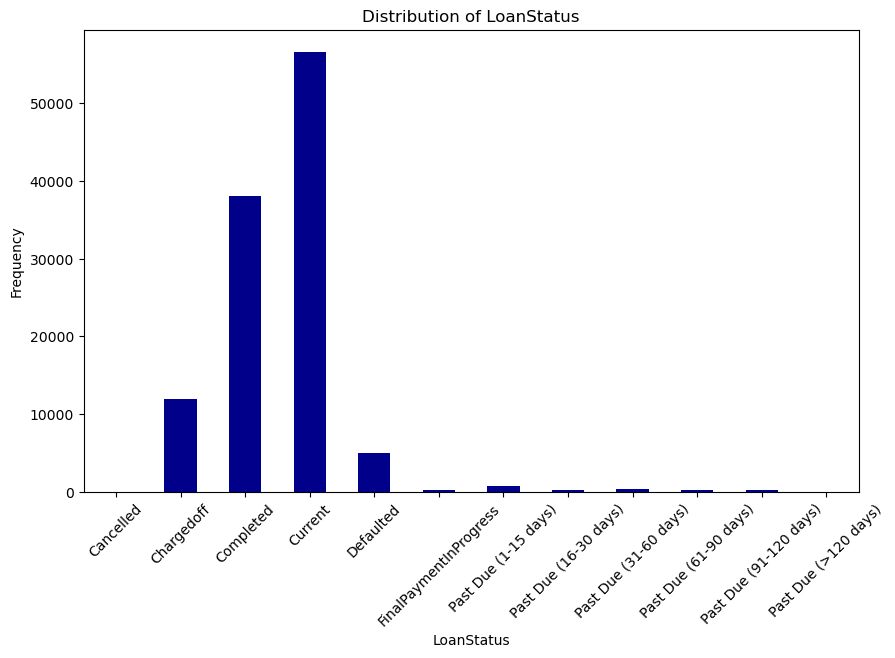

In [8]:
significant_variables = [
    'Term', 
    'LoanStatus'
]

for variable in significant_variables:
    plt.figure(figsize=(10, 6))
    aggregated_data = df.groupby(variable).size()
    aggregated_data.plot(kind='bar', color='darkblue')
    plt.title(f'Distribution of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

My ultimate purpose is to analyze the differences between loans that completed and those that defaulted.  Let's start searching for correlations between other variables and those LoanStatus values.

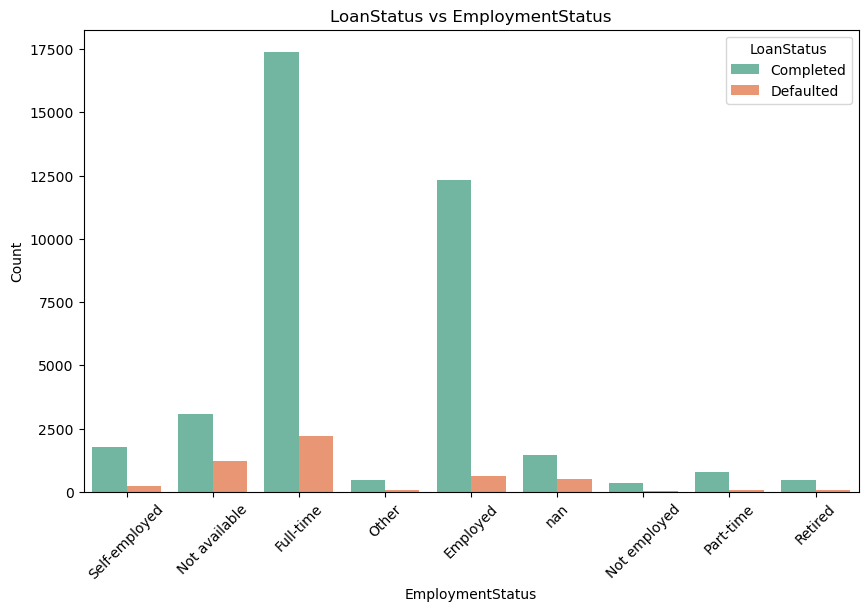

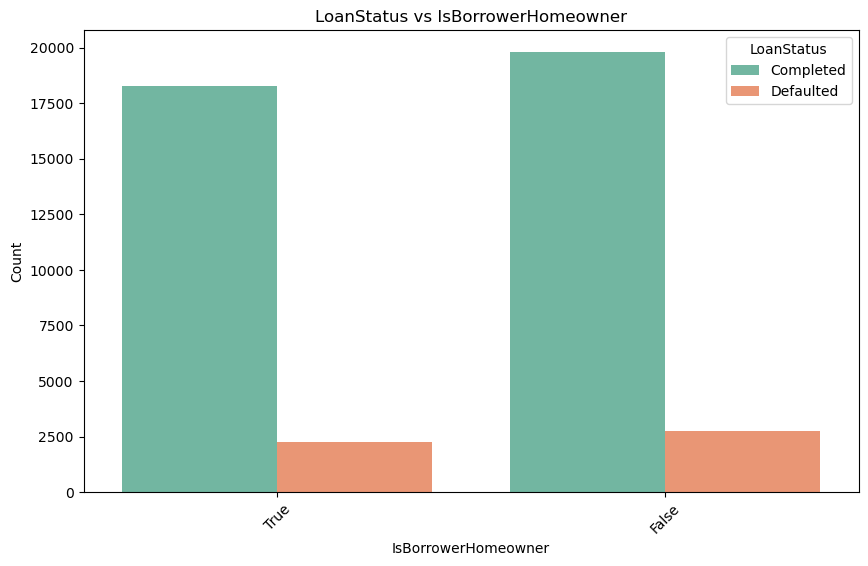

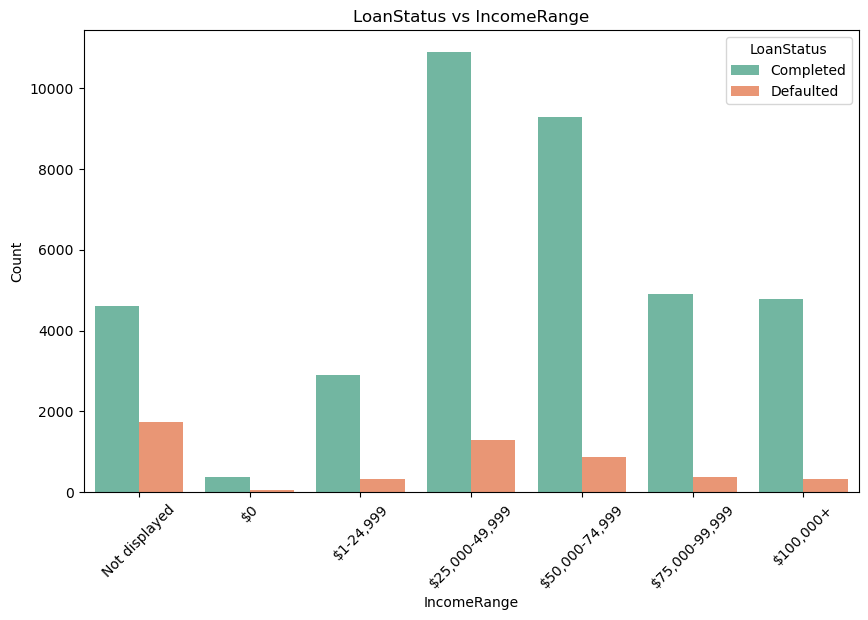

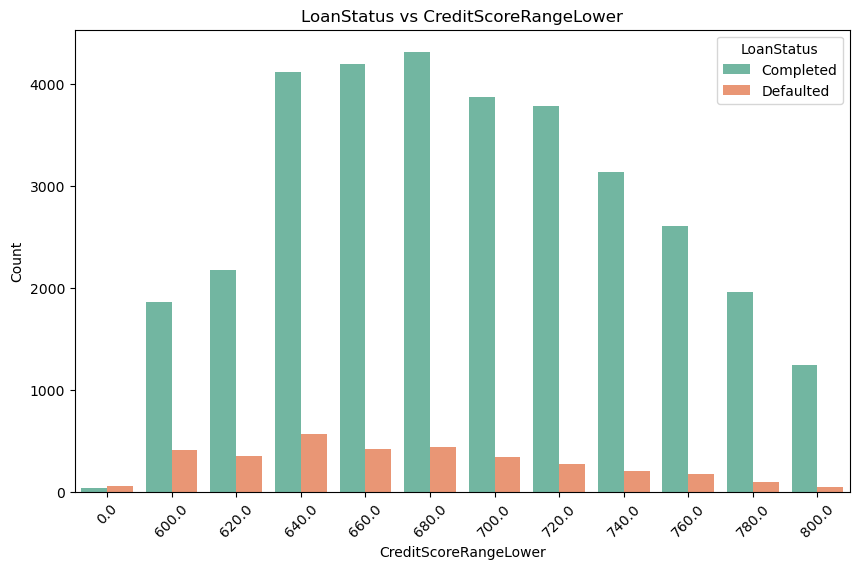

In [9]:
import seaborn as sns

df = df.astype(str)

selected_columns = [
    'EmploymentStatus', 'IsBorrowerHomeowner', 'IncomeRange', 
    'CreditScoreRangeLower',
]

credit_score_order = [
    '0.0', '600.0', '620.0', '640.0', '660.0', '680.0', '700.0', '720.0', '740.0', '760.0', '780.0', '800.0'
]

income_range_order = [
    'Not displayed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', 
    '$75,000-99,999', '$100,000+'
]

df_filtered = df[df['LoanStatus'].isin(['Completed', 'Defaulted'])]
df_filtered = df_filtered[['LoanStatus'] + selected_columns]

for column in selected_columns:
    plt.figure(figsize=(10, 6))
    order = income_range_order if column == 'IncomeRange' else credit_score_order if column == 'CreditScoreRangeLower' else None
    sns.countplot(x=column, hue='LoanStatus', data=df_filtered, palette='Set2', order=order)
    plt.title(f'LoanStatus vs {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='LoanStatus', loc='upper right')
    plt.show()

It's hard to notice clear trends about which customers are more likely to default, since for most of the categories in which there is a higher number of defaults (e.g., those who are not homeowners), there are also a higher number of completed loans.  Now that I've converted all of the values to strings for the graphing above, I'm going to convert two columns - 'LoanOriginalAmount' and 'MonthlyLoanPayment' - back into numbers so that I can break their continuous values into discrete bins.  

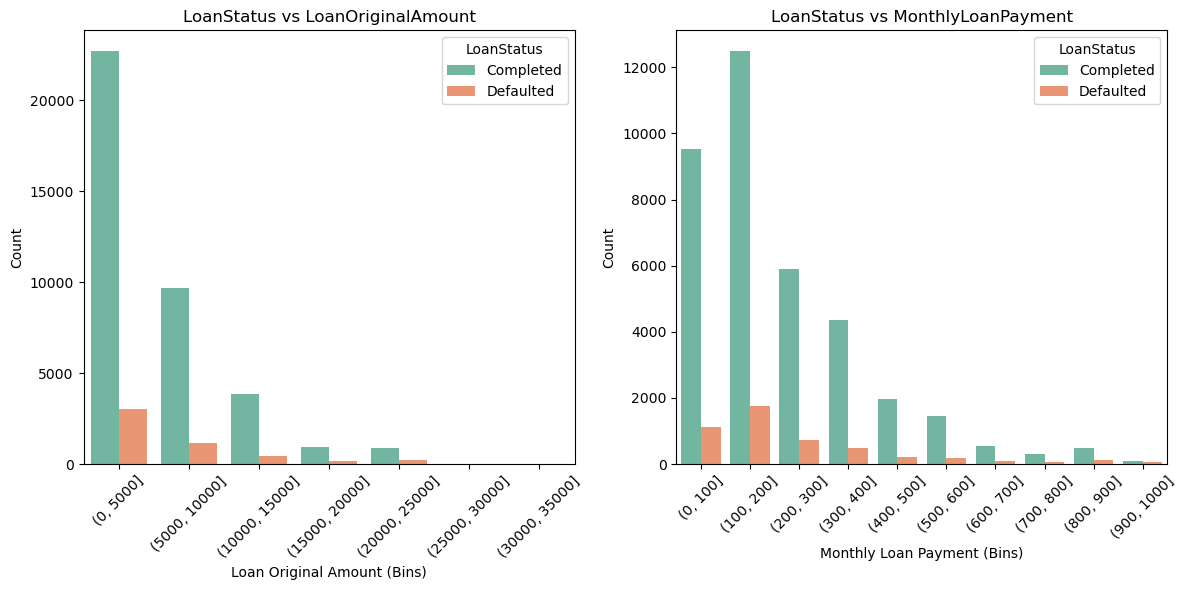

In [22]:
df['LoanOriginalAmount'] = pd.to_numeric(df['LoanOriginalAmount'], errors='coerce')
df['MonthlyLoanPayment'] = pd.to_numeric(df['MonthlyLoanPayment'], errors='coerce')

loan_amount_bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000]
loan_payment_bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

df['LoanOriginalAmount_bin'] = pd.cut(df['LoanOriginalAmount'], bins=loan_amount_bins)
df['MonthlyLoanPayment_bin'] = pd.cut(df['MonthlyLoanPayment'], bins=loan_payment_bins)

df_filtered = df[df['LoanStatus'].isin(['Completed', 'Defaulted'])]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='LoanOriginalAmount_bin', hue='LoanStatus', data=df_filtered, palette='Set2')
plt.title('LoanStatus vs LoanOriginalAmount')
plt.xlabel('Loan Original Amount (Bins)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='LoanStatus')

plt.subplot(1, 2, 2)
sns.countplot(x='MonthlyLoanPayment_bin', hue='LoanStatus', data=df_filtered, palette='Set2')
plt.title('LoanStatus vs MonthlyLoanPayment')
plt.xlabel('Monthly Loan Payment (Bins)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='LoanStatus')

plt.tight_layout()
plt.show()

Again, there are no clear indicators for who will default, since the categories in which there are the most defaults also have the most completed borrowers.  I would like to use a machine learning algorithm to identify which borrowers are most likely to default, but first I will use try-except blocks to identify which columns are of the wrong data type.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

selected_columns = [
    'EmploymentStatus', 
    'IncomeRange', 
    'CreditScoreRangeLower', 
    'LoanStatus'
]

df_filtered = df[selected_columns].dropna()

df_filtered = pd.get_dummies(df_filtered, columns=['EmploymentStatus', 'IncomeRange'], drop_first=True)

X = df_filtered.drop('LoanStatus', axis=1)
y = df_filtered['LoanStatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

/Users/micah.isser/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/micah.isser/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6901414756446992
Classification Report:
                        precision    recall  f1-score   support

            Chargedoff       0.00      0.00      0.00      2357
             Completed       0.64      0.60      0.62      7298
               Current       0.71      0.97      0.82     11363
             Defaulted       0.48      0.01      0.02       869
FinalPaymentInProgress       0.00      0.00      0.00        36
  Past Due (1-15 days)       0.00      0.00      0.00       155
 Past Due (16-30 days)       0.00      0.00      0.00        48
 Past Due (31-60 days)       0.00      0.00      0.00        75
 Past Due (61-90 days)       0.00      0.00      0.00        69
Past Due (91-120 days)       0.00      0.00      0.00        64
  Past Due (>120 days)       0.00      0.00      0.00         2

              accuracy                           0.69     22336
             macro avg       0.17      0.14      0.13     22336
          weighted avg       0.59      0.69      0

/Users/micah.isser/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/micah.isser/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model uses a combination of the borrower's employment status, income range, and credit score to make a prediction about who will default on their loans.  The machine learning method is a logistic regression, which is good for bringing together multiple variables to produce a clear outcome.  The accuracy for the algorithm is 0.69, which means that it can account for roughly 69% of the variance in who defaults on their loans.  As a last step, let's use the measures of precision, recall, and the f1 score (which is a combination of the two) to assess how successful the algorithm is.  

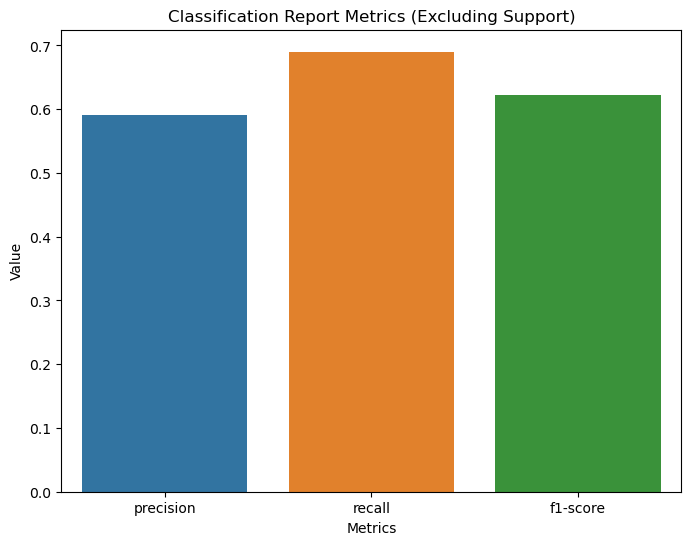

In [36]:

plt.figure(figsize=(8, 6))
sns.barplot(x=[k for k in report['weighted avg'].keys() if k != 'support'], 
            y=[v for k, v in report['weighted avg'].items() if k != 'support'])
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Classification Report Metrics (Excluding Support)')
plt.show()